#### Camvid Segmentation using Segmentation Models pytorch ####

In [1]:
## Importing the necessary packages ##

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as smp_utils
from torchvision.utils import make_grid , draw_segmentation_masks

import albumentations as albu
from albumentations.pytorch import ToTensorV2

import os
from glob import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt

print('All necessary packages are imported!!')

d:\cam_vid\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All necessary packages are imported!!


With all the necessary packages imported, lets now get our hands and start creating our dataset.

In [2]:
## Creating a Pytorch based Dataset Class ##

class CamVidDataset(Dataset):
    '''
    Creates the dataset for pytorch model usage.
    '''

    def __init__(self , images_dir , masks_dir , seg_class , aug = False , preprocess = None , train = True , vis = False) -> None:
        super().__init__()

        self.images = glob(images_dir + '/*')
        self.masks = glob(masks_dir + '/*')

        assert(len(self.images) == len(self.masks)) , 'There are not equal numbers of images and segmentation masks'

        self.class_names = ['sky', 'building', 'pole', 'road', 'pavement', 
                        'tree', 'signsymbol', 'fence', 'car', 
                        'pedestrian', 'bicyclist', 'unlabelled']

        self.class_val = [self.class_names.index(val.lower()) for val in seg_class]
        self.aug = aug
        self.train = train
        self.preprocess = preprocess
        self.vis = vis

    def __getitem__(self, index):
        
        img_file = self.images[index]
        mask_file = self.masks[index]

        img = cv2.imread(img_file)
        img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_file , 0)
        masks = [(mask == v) for v in self.class_val]
        mask = np.stack(masks , axis = -1).astype('float')
        
        if self.aug:
            img , mask = self._aug(image = img , mask = mask)

        if self.preprocess is not None:
            img , mask = self._preprocess(image = img , mask = mask , preprocess = self.preprocess)

        return img , mask

    def __len__(self):
        return len(self.images)

    def _aug(self , image , mask):
        
        if self.train and self.vis == True:
            transform = albu.Compose([
                albu.HueSaturationValue(p = 0.4),
                albu.OneOf([
                    albu.GaussNoise(p=0.2),
                    albu.ISONoise(p = 0.4)
                    ] , p = 0.3) ,
                albu.OneOf([
                    albu.RandomRain(p = 0.2),
                    albu.RandomSnow(p = 0.2) , 
                    albu.RandomShadow(p = 0.2),
                    albu.RandomSunFlare(p=0.2)
                    ] , p = 0.25) ,
                albu.OneOf([
                    albu.IAASharpen(p=1),
                    albu.Blur(blur_limit=3, p=1),
                    albu.MotionBlur(blur_limit=3, p=1),
                    ], p=0.9,) ,
                albu.Resize(256 , 256) , 
                ToTensorV2()  
            ])

            
        elif self.train and self.vis == False:
            transform = albu.Compose([
                albu.HueSaturationValue(p = 0.4),
                albu.OneOf([
                    albu.GaussNoise(p=0.2),
                    albu.ISONoise(p = 0.4)
                    ] , p = 0.3) ,
                albu.OneOf([
                    albu.RandomRain(p = 0.2),
                    albu.RandomSnow(p = 0.2) , 
                    albu.RandomShadow(p = 0.2),
                    albu.RandomSunFlare(p=0.2)
                    ] , p = 0.25) ,
                albu.OneOf([
                    albu.IAASharpen(p=1),
                    albu.Blur(blur_limit=3, p=1),
                    albu.MotionBlur(blur_limit=3, p=1),
                    ], p=0.9,) ,
                albu.Resize(256 , 256) , ])

        elif self.aug == False and self.vis == True:
            transform = albu.Compose(
                [albu.Resize(256 , 256) ,
                ToTensorV2()
            ])

        else:
            transform = albu.Compose(
                [albu.Resize(256 , 256) ,

            ])
        
        sample = transform(image = image , mask = mask)

        return sample['image'] , sample['mask']

    def _to_tensor(self , x, **kwargs):
        return x.transpose(2, 0, 1).astype('float32')

    def _preprocess(self , image , mask , preprocess):

        transform = albu.Compose([
            albu.Lambda(image = preprocess),
            albu.Lambda(image = self._to_tensor , mask = self._to_tensor)
        ])
        
        sample = transform(image = image , mask = mask)

        return sample['image'] , sample['mask'] 

d:\cam_vid\venv\lib\site-packages\albumentations\imgaug\transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)


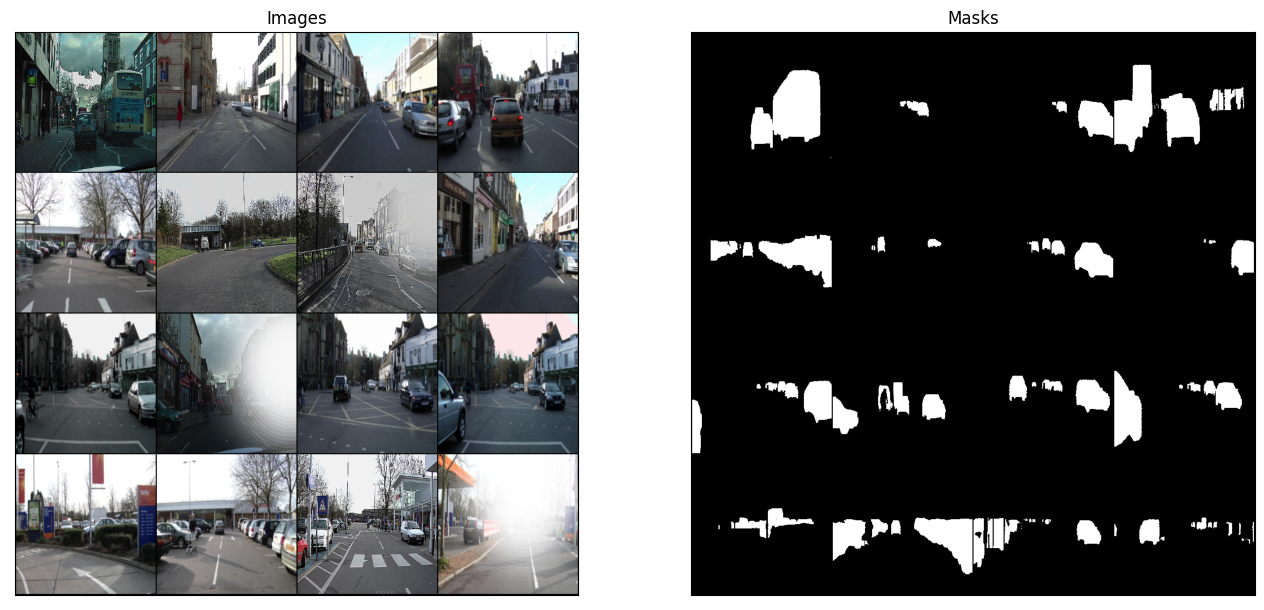

In [3]:
## Checking the dataset ##

dummy_dataset = CamVidDataset(images_dir='CamVid/train' , 
                              masks_dir='CamVid/trainannot' , 
                              seg_class=['car'] , 
                              aug = True , 
                              train = True ,
                              vis = True)

dummy_dl = DataLoader(dummy_dataset , 
                      batch_size = 16 , 
                      shuffle = True)


for batch in dummy_dl:
    img , mask = batch
    mask = mask.permute(0 , 3 , 1 , 2)

    plt.figure(figsize = (16 , 8))

    plt.subplot(1 , 2 , 1)
    plt.title('Images')
    plt.xticks(ticks = [] , labels = [])
    plt.yticks(ticks = [] , labels = [])
    plt.imshow(make_grid(img , nrow = 4).permute(1 , 2  , 0))
    
    plt.subplot(1 , 2 , 2)
    plt.title('Masks')
    plt.xticks(ticks = [] , labels = [])
    plt.yticks(ticks = [] , labels = [])
    
    plt.imshow(make_grid(mask.squeeze(-1) , nrow = 4).permute(1 , 2  , 0))
    
    break
    

One might feel that this is it for the dataset generation, right?

But no. This is not over. 

Since we are going to use Segmentation models pytorch for our model/network, we need to utilise the given preprocessing for the type of network we want to use. So, before setting our dataset, lets set our model to get the necessary preprocessing and thereafter set our dataset.

So, lets get started with the model creation.

In [4]:
## Creating our model ##

ENCODER = 'resnet18'
WEIGHTS = 'imagenet'
CLASSES = ['car']
ACTIVATION = 'sigmoid'
DEVICE = 'cuda'

model = smp.Unet(encoder_name = ENCODER , 
                 encoder_weights = WEIGHTS ,
                 classes = len(CLASSES) , 
                 activation = ACTIVATION)

preprocessing_function = smp.encoders.get_preprocessing_fn(ENCODER , WEIGHTS)

print('Model is loaded !!')

Model is loaded !!


Now, we are ready to create our dataset and invoke the training routine.

In [5]:
## Making the training and testing dataset ##

train_dataset = CamVidDataset(images_dir = 'CamVid/train' , 
                              masks_dir = 'CamVid/trainannot',
                              seg_class = CLASSES , 
                              aug = True , 
                              preprocess = preprocessing_function , 
                              train = True ,
                              vis = False)

val_dataset = CamVidDataset(images_dir = 'CamVid/val' , 
                            masks_dir = 'CamVid/valannot',
                            seg_class = CLASSES , 
                            aug = True , 
                            preprocess = preprocessing_function ,
                            train = False,
                            vis = False)


print('All dataset loaded!!')

All dataset loaded!!


In [6]:
## Now we must make Pytorch Dataloader instances of these datasets to feed in batches of data ##

train_dl = DataLoader(train_dataset , batch_size = 16 , shuffle = True)
valid_dl = DataLoader(val_dataset , batch_size = 16 , shuffle = True)

print('Dataloader instances created !!')

Dataloader instances created !!


We are almost ready for our training epochs but we must set the optimizer and the loss function along with the evaluation metrics.

So lets do that now.

In [7]:
## Putting together the loss function, optimizer and the evaluation metric ##

loss = smp_utils.losses.DiceLoss()

eval_metric = [smp_utils.metrics.IoU(threshold = 0.5)]

optim = torch.optim.Adam(model.parameters() , lr = 1e-4)  

Now, its time- time for what? The trainingggg...

Go go go now and set up the training and validation epochs.

In [8]:
## Setting the training and the validation epoch ##

train_epoch = smp_utils.train.TrainEpoch(
    model , 
    loss = loss ,
    metrics = eval_metric , 
    optimizer = optim ,
    device = DEVICE , 
    verbose = True
)


val_epoch = smp_utils.train.ValidEpoch(
    model , 
    loss = loss ,
    metrics = eval_metric ,
    device = DEVICE , 
    verbose = True
)

In [9]:
## Now training the model for 50 epochs ##

NUM_EPOCHS = 50

max_score = 0

for i in range(NUM_EPOCHS):
    print('Epoch number : {} / {}'.format(i + 1 , NUM_EPOCHS))
    train_logs = train_epoch.run(train_dl)
    val_logs = val_epoch.run(valid_dl)

    if max_score < val_logs['iou_score']:
        max_score = val_logs['iou_score']
        torch.save(model , 'saved_models/model_{}.pth'.format(i))
        print('Model saved at epoch {}!'.format(i + 1))

    if i == 25:
        optim.param_groups[0]['lr'] = 1e-5
        print('Learning rate decayed!!')

Epoch number : 1 / 50
valid: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s, dice_loss - 0.9154, iou_score - 0.1029] 
Model saved at epoch 1!
Epoch number : 2 / 50
valid: 100%|██████████| 7/7 [00:02<00:00,  2.34it/s, dice_loss - 0.8853, iou_score - 0.2299]
Model saved at epoch 2!
Epoch number : 3 / 50
valid: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s, dice_loss - 0.8594, iou_score - 0.4438]
Model saved at epoch 3!
Epoch number : 4 / 50
valid: 100%|██████████| 7/7 [00:03<00:00,  2.31it/s, dice_loss - 0.8423, iou_score - 0.4948]
Model saved at epoch 4!
Epoch number : 5 / 50
valid: 100%|██████████| 7/7 [00:03<00:00,  2.31it/s, dice_loss - 0.8276, iou_score - 0.5611]
Model saved at epoch 5!
Epoch number : 6 / 50
valid: 100%|██████████| 7/7 [00:03<00:00,  2.31it/s, dice_loss - 0.7761, iou_score - 0.5937]
Model saved at epoch 6!
Epoch number : 7 / 50
valid: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s, dice_loss - 0.76, iou_score - 0.6747]  
Model saved at epoch 7!
Epoch number : 8 / 50
vali

Our training loop is done.

So what's next??

Next is checking the evaluation score of the testing dataset.

In [10]:
## Setting the testing dataloader ##

test_dataset = CamVidDataset(images_dir = 'CamVid/test' , 
                            masks_dir = 'CamVid/testannot',
                            seg_class = CLASSES , 
                            aug = True , 
                            preprocess = preprocessing_function ,
                            train = False,
                            vis = False)

test_dl = DataLoader(test_dataset , batch_size = 1 , shuffle = True)

In [11]:
## Putting the test run ##

glob('saved_models' + '/*')[-1]

test_epoch = smp_utils.train.ValidEpoch(
    model = torch.load(glob('saved_models' + '/*')[-1]) ,
    loss = loss , 
    metrics = eval_metric ,
    device = DEVICE
)

logs = test_epoch.run(test_dl)

valid: 100%|██████████| 233/233 [00:11<00:00, 20.68it/s, dice_loss - 0.7082, iou_score - 0.5623]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 1, 256, 256])


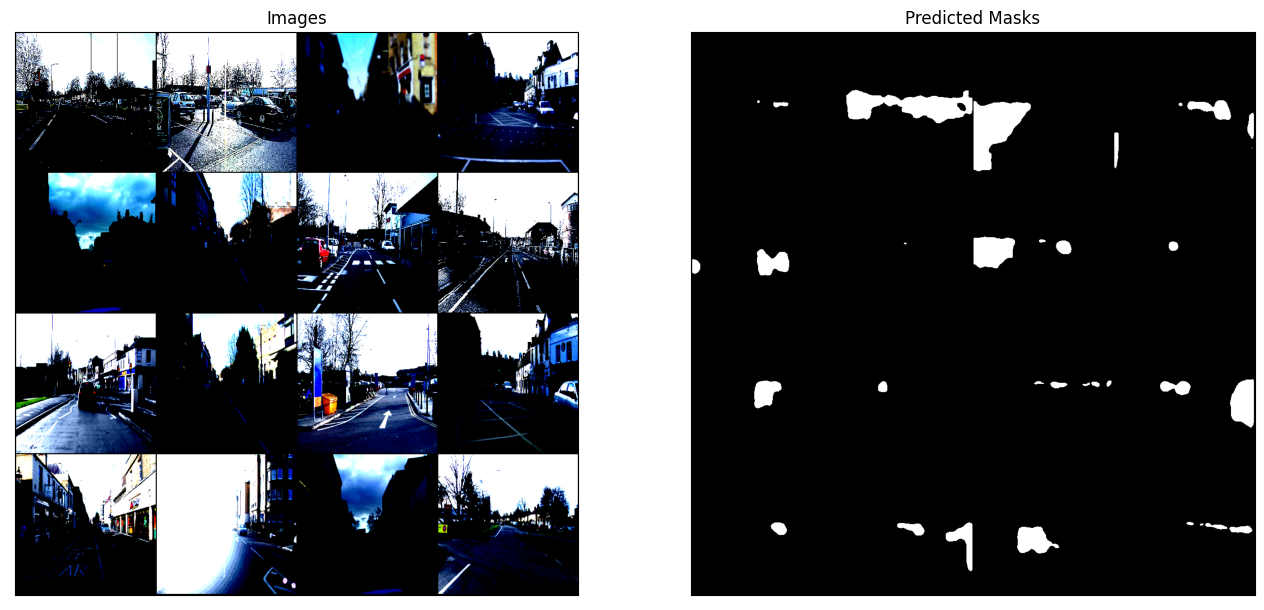

In [12]:
## Now its always better to visualize prediction ##

test_vis_dataset = CamVidDataset(images_dir = 'CamVid/test' , 
                            masks_dir = 'CamVid/testannot',
                            seg_class = CLASSES , 
                            aug = True , 
                            preprocess = preprocessing_function ,
                            train = False,
                            vis = True)


test_vis_dl = DataLoader(test_vis_dataset , batch_size = 16 , shuffle = False)

model = torch.load(glob('saved_models' + '/*')[-1])

for batch in train_dl:
    img , _ = batch
    #img = image.numpy()
    pred = model(img.cuda())
    print(pred.shape)
    plt.figure(figsize = (16 , 8))

    plt.subplot(1 , 2 , 1)
    plt.title('Images')
    plt.xticks(ticks = [] , labels = [])
    plt.yticks(ticks = [] , labels = [])
    plt.imshow(make_grid(img.cpu().detach() , nrow = 4).permute(1 , 2  , 0))
    
    plt.subplot(1 , 2 , 2)
    plt.title('Predicted Masks')
    plt.xticks(ticks = [] , labels = [])
    plt.yticks(ticks = [] , labels = [])
    
    plt.imshow(make_grid(pred.squeeze(-1).cpu().detach().round() , nrow = 4).permute(1 , 2  , 0))
    
    break
    